In [1]:
# importing packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.linalg import norm
from scipy.special import ellipj

Q2.0
---

In [2]:
## Q2.0
#(1)
def newton(F, DF, x0, eps, K):
    x = x0
    count = 0
    while (norm(F(x)) > eps) & (count < K):
        y = np.linalg.solve(DF(x), F(x))
        x -= y
        count += 1
    return x, count

#(2)
def backwardEuler(f,Df, t0, y0, h):
    m = len(y0)
    F = lambda d: d - f(t0 + h, y0 + h*d)
    DF = lambda g: np.eye(m)-h*Df(t0+h, y0 + h*g)
    delta, redundant = newton(F, DF, f(t0+h, y0), h*h*1e-5, 1000)    
    y1 = y0 + h*delta
    return y1

## Defining functions we need
#forward euler method
def forwardEuler(f, Df, tn, yn, h):
    return yn + h * f(tn,yn)

# Method from Q11 Quiz 1
def Q11(f,Df, t0,y0, h):
    f0 = f(t0,y0)
    f1 = f(t0+h, y0+h*f0)
    return y0 + h/2*(f0+f1)

# evolve method
def evolve(phi,f,Df, t0,y0, T,N):
    h = T/N # could also be h=(T-t0)/N
    y = np.zeros([N+1, len(y0)])
    t = np.zeros( N+1 )
    y[0] = y0
    t[0] = 0   # could be t[0]=t0
    for i in range(N):
        y[i+1] = phi(f,Df, t[i],y[i], h)
        t[i+1] = t[i]+h
    return t,y

# compute EOCs method
def computeEocs(herr):
    eoc_vals = []
    for i in range(0, len(herr[:,0])-1):
        eoc = np.log(herr[i+1,1]/herr[i,1])/np.log(herr[i+1,0]/herr[i,0])
        eoc_vals.append(eoc)
    eoc_vals = np.array(eoc_vals)
    return eoc_vals

Q2.1
---

,h,FE-error,FE-eoc,BE-error,BE-eoc,Q11-error,Q11-eoc,CN-error,CN-eoc
0,4.0000e-01,1.197520e+00,nan,1.169340e+00,nan,2.336009e-01,nan,1.853746e-01,nan
1,2.0000e-01,3.849013e-01,1.637,1.949440e-01,2.585,5.724377e-02,2.029,4.250296e-02,2.125
2,1.0000e-01,1.424462e-01,1.434,1.058020e-01,0.882,1.252991e-02,2.192,1.013313e-02,2.068
3,5.0000e-02,6.525497e-02,1.126,5.635233e-02,0.909,2.894328e-03,2.114,2.522717e-03,2.006
4,2.5000e-02,3.135656e-02,1.057,2.914622e-02,0.951,6.889803e-04,2.071,6.287615e-04,2.004
5,1.2500e-02,1.538350e-02,1.027,1.483127e-02,0.975,1.680073e-04,2.036,1.571657e-04,2.000
6,6.2500e-03,7.620535e-03,1.013,7.482302e-03,0.987,4.148271e-05,2.018,3.928423e-05,2.000
7,3.1250e-03,3.792678e-03,1.007,3.758094e-03,0.993,1.030578e-05,2.009,9.820607e-06,2.000
8,1.5625e-03,1.891968e-03,1.003,1.883324e-03,0.997,2.568356e-06,2.005,2.455153e-06,2.000
9,7.8125e-04,9.448989e-04,1.002,9.427381e-04,0.998,6.410798e-07,2.002,6.137861e-07,2.000


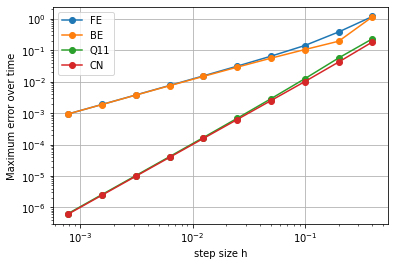

In [3]:
## Q2.1
# Crank-Nicholson method
def CN(f, Df, t0, y0, h):
    m = len(y0)
    F = lambda d: d - 0.5*f(t0 + h, y0 + h*d) - 0.5*f(t0, y0)
    DF = lambda g: np.eye(m)-0.5*h*Df(t0+h, y0 + h*g)
    delta, _ = newton(F, DF, f(t0+h, y0), h*h*1e-5, 1000)
    y1 = y0 + (h)*delta
    return y1

#calculating the exact solution
def Y1(t):
    y1 = (2*(np.e**t))/(2*(np.e**t)-1)
    y2 = (-2*(np.e**t))/(4*(np.e**(2*t)) - 4*(np.e**(t)) + 1)
    return np.array([y1, y2])

#writing right hand side of ODE
def RHS1(t, y):
    y1 = y[0]
    y2 = y[1]
    f1 = np.array([y2, y2*(1 - 2*y1)])
    return f1

# function to work out the errors and EOCs
def experiment(stepper, M, N0, f, Df, Y, T, y0):
    herr = np.zeros( [M,2] )
    for m in range(M):
        N = N0*2**m
        t,y = evolve( stepper, f, Df, 0, y0, T, N)
        herr[m] = [T/N, 0]
        for tn,yn in zip(t,y):
            herr[m][1] = max(herr[m][1], norm(yn-Y(tn)) )

    eoc = computeEocs( herr )
    eoc = np.hstack( [ [np.nan],eoc ] )
    res = np.hstack( [herr, np.atleast_2d(eoc).T] )

    return res

# working out results
y01 = [2, -2]
T1 = 10
N01 = 25
M1 = 10
Df1 = lambda t, y: np.array([[0, 1], [-2*y[1], 1-2*y[0]]])

resFE = experiment(forwardEuler, M1, N01, RHS1, Df1, Y1, T1, y01)
resBE = experiment(backwardEuler, M1, N01, RHS1, Df1, Y1, T1, y01)
resQ11 = experiment(Q11, M1, N01, RHS1, Df1, Y1, T1, y01)
resCN = experiment(CN, M1, N01, RHS1, Df1, Y1, T1, y01)

def compareErrors(results):
    # columns of table
    simul = list(results.keys())
    columns=['h'] + [s for n in simul for s in [f'{n}-error', f'{n}-eoc']]
    # values in tablea
    keys   = {columns[0]: results[simul[0]][:,0]} # all results are assumed to use the same sequence of h
    styles = {columns[0]: '{:.4e}'}
    for i, k in enumerate(simul):
        keys[columns[2*i+1]]   = results[k][:,1] # errors
        styles[columns[2*i+1]] = '{:.6e}'
        keys[columns[2*i+2]]   = results[k][:,2] # eocs
        styles[columns[2*i+2]] = '{:.3f}'

    # generate table
    table = pd.DataFrame(keys, index=range(results[simul[0]].shape[0]), # all results must have the same shape
            columns=columns)

    # format floating points for each column for jupyter output (does not work in pdf)
    display( table.style.format(styles) )

    for i,k in enumerate(simul):
        plt.loglog(results[k][:,0],results[k][:,1],marker='o',label=k)
    plt.legend()
    plt.grid(True)
    plt.xlabel("step size h")
    plt.ylabel("Maximum error over time")
    plt.savefig("Q2_compareErr.pdf", format="pdf", bbox_inches="tight") # output to pdf for inclusing in tex document
    plt.show()

# Plotting results
compareErrors({"FE":resFE, "BE":resBE, "Q11":resQ11, "CN":resCN})

We see from our table that the EOCs for the Crank-Nicholson method converge to 2 which implies that the method converges with order $O(h)$.
We see from our graph that the Q11 method and the Crank-Nicholson method  have almost identical maximum errors for the step sizes we have chosen.
This is also true for the forward Euler and backward Euler methods.

Q2.2
---
(Dicsussed at the bottom however trajectories discussed here)

In [4]:
### Q2.2
## r=4
# writing RHS of our Hamiltonian System
def RHS2(t, y):
    x = y[0]
    p = y[1]
    return np.array([p, -((0.8**2) + 1)*x + 2*(0.8**2)*(x**3)])

# Finding Exact solutions
def Y2(t):
    sn , cn , dn , _ = ellipj (t, 0.8*0.8)
    return np.array([ sn , cn * dn ])

# Calculating results
y02 = [0, 1]
T2 = 40
N02 = 150
M2 = 11
Df2 = lambda t, y: np.array([[0, 1], [(-0.8)**2 - 1 + 6*(0.8**2)*y[0]**3, 0]])

hamBE = experiment(backwardEuler, M2, N02, RHS2, Df2, Y2, T2, y02)
hamQ11 = experiment(Q11, M2, N02, RHS2, Df2, Y2, T2, y02)
hamCN = experiment(CN, M2, N02, RHS2, Df2, Y2, T2, y02)

#compareErrors({"BE":hamBE, "Q11":hamQ11, "CN":hamCN})

## r=2
# Writing RHS of our Hamiltonian System
def RHS3(t, y):
    x = y[0]
    p = y[1]
    return np.array([p, -1*x])

# Finding Exact solutions
def Y3(t):
    x = np.sin(t)
    p = np.cos(t)
    return np.array([x, p])

# Calculating results
y03 = [0, 1]
T3 = 40
N03 = 150
M3 = 11
Df3 = lambda t, y: np.array([[0, 1], [-1, 0]])

my_hamBE = experiment(backwardEuler, M3, N03, RHS3, Df3, Y3, T3, y03)
my_hamQ11 = experiment(Q11, M3, N03, RHS3, Df3, Y3, T3, y03)
my_hamCN = experiment(CN, M3, N03, RHS3, Df3, Y3, T3, y03)


C:\Users\njkel\AppData\Local\Temp/ipykernel_16804/3451696733.py:7: RuntimeWarning: overflow encountered in double_scalars
  return np.array([p, -((0.8**2) + 1)*x + 2*(0.8**2)*(x**3)])
C:\Users\njkel\AppData\Local\Temp/ipykernel_16804/3451696733.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return np.array([p, -((0.8**2) + 1)*x + 2*(0.8**2)*(x**3)])
C:\Users\njkel\AppData\Local\Temp/ipykernel_16804/3532948634.py:48: RuntimeWarning: divide by zero encountered in log
  eoc = np.log(herr[i+1,1]/herr[i,1])/np.log(herr[i+1,0]/herr[i,0])


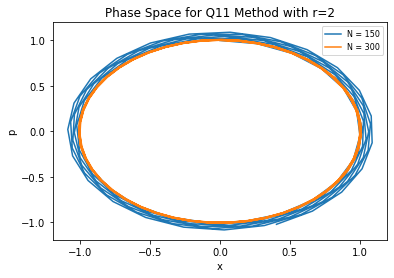

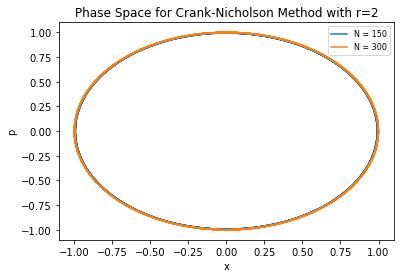

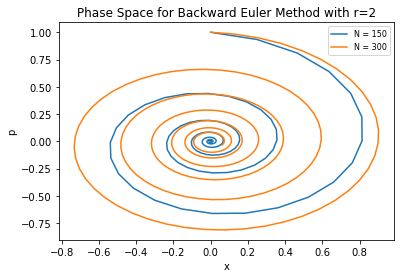

C:\Users\njkel\AppData\Local\Temp/ipykernel_16804/3451696733.py:7: RuntimeWarning: overflow encountered in double_scalars
  return np.array([p, -((0.8**2) + 1)*x + 2*(0.8**2)*(x**3)])
C:\Users\njkel\AppData\Local\Temp/ipykernel_16804/3451696733.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return np.array([p, -((0.8**2) + 1)*x + 2*(0.8**2)*(x**3)])


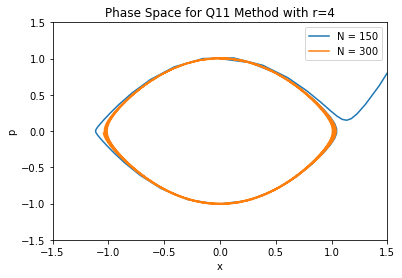

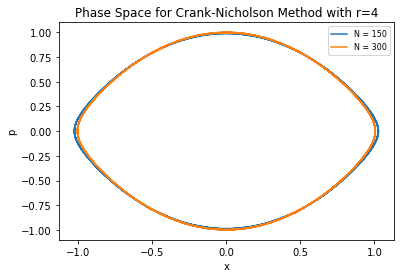

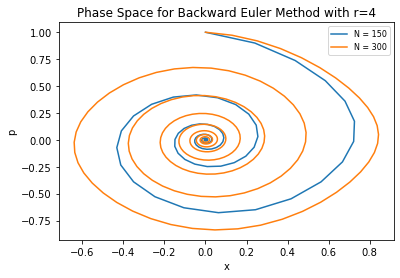

In [5]:
### Plotting Trajectories
## r=2
# Q11 Method
_, Q11_y_0 = evolve(Q11, RHS3, Df3, 0, y03, T3, 150)
_, Q11_y_1 = evolve(Q11, RHS3, Df3, 0, y03, T3, 300)
plt.plot(Q11_y_0[:,0], Q11_y_0[:,1], label='N = 150')
plt.plot(Q11_y_1[:,0], Q11_y_1[:,1], label='N = 300')
plt.xlabel('x')
plt.ylabel('p')
plt.title('Phase Space for Q11 Method with r=2')
plt.legend(loc='upper right', fontsize=8)
plt.show()

# Crank-Nicholson Method
_, CN_y_0 = evolve(CN, RHS3, Df3, 0, y03, T3, 150)
_, CN_y_1 = evolve(CN, RHS3, Df3, 0, y03, T3, 300)
plt.plot(CN_y_0[:,0], CN_y_0[:,1], label='N = 150')
plt.plot(CN_y_1[:,0], CN_y_1[:,1], label='N = 300')
plt.xlabel('x')
plt.ylabel('p')
plt.title('Phase Space for Crank-Nicholson Method with r=2')
plt.legend(loc='upper right', fontsize=8)
plt.show()

# Backward Euler Method
_, BE_y_0 = evolve(backwardEuler, RHS3, Df3, 0, y03, T3, 150)
_, BE_y_1 = evolve(backwardEuler, RHS3, Df3, 0, y03, T3, 300)
plt.plot(BE_y_0[:,0], BE_y_0[:,1], label='N = 150')
plt.plot(BE_y_1[:,0], BE_y_1[:,1], label='N = 300')
plt.xlabel('x')
plt.ylabel('p')
plt.title('Phase Space for Backward Euler Method with r=2')
plt.legend(loc='upper right', fontsize=8)
plt.show()

## r=4
# Q11 Method
_, r4_Q11_y_0 = evolve(Q11, RHS2, Df2, 0, y02, T2, 150)
_, r4_Q11_y_1 = evolve(Q11, RHS2, Df2, 0, y02, T2, 300)
plt.plot(r4_Q11_y_0[:,0], r4_Q11_y_0[:,1], label='N = 150')
plt.plot(r4_Q11_y_1[:,0], r4_Q11_y_1[:,1], label='N = 300')
plt.xlabel('x')
plt.ylabel('p')
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.title('Phase Space for Q11 Method with r=4')
plt.legend()
plt.show()

# Crank-Nicholson Method
_, r4_CN_y_0 = evolve(CN, RHS2, Df2, 0, y02, T2, 150)
_, r4_CN_y_1 = evolve(CN, RHS2, Df2, 0, y02, T2, 300)
plt.plot(r4_CN_y_0[:,0], r4_CN_y_0[:,1], label='N = 150')
plt.plot(r4_CN_y_1[:,0], r4_CN_y_1[:,1], label='N = 300')
plt.xlabel('x')
plt.ylabel('p')
plt.title('Phase Space for Crank-Nicholson Method with r=4')
plt.legend(loc='upper right', fontsize=8)
plt.show()

# Backward Euler Method
_, r4_BE_y_0 = evolve(backwardEuler, RHS2, Df2, 0, y02, T2, 150)
_, r4_BE_y_1 = evolve(backwardEuler, RHS2, Df2, 0, y02, T2, 300)
plt.plot(r4_BE_y_0[:,0], r4_BE_y_0[:,1], label='N = 150')
plt.plot(r4_BE_y_1[:,0], r4_BE_y_1[:,1], label='N = 300')
plt.xlabel('x')
plt.ylabel('p')
plt.title('Phase Space for Backward Euler Method with r=4')
plt.legend(loc='upper right', fontsize=8)
plt.show()

(1) In this figure we see that the method is stable and doesn't spiral outwards. For bigger N we see even less variation in x and p.

(2) In this figure we observe again that the method is stable when applied to our system. The trajectory does not vary even with smaller or larger N.

(3) In this figure we see that the trajectory of the phase plane spirals inwards from (0,1). For larger N we see that the spiral inwards is larger.

(4) In this final figure we see that the method orbits in a pointed ovular shape. For $N=150$ we see that the trajectory becomes unbounded and goes off to infinity. For $N=300$ we see that the method remains stable when applied here.

(5) Similar to last figure the method orbits in a pointed ovular shape. However this time the method does not become unbounded for $N=150$ or $N=300$.

(6) Similar to figure 3 the trajetory spirals inwards form (0,1), our inital condition. For larger N we see that the spiral inwards is larger.

Q2.3
---
(Discussed at the bottom)

In [6]:
#### Q2.3
### Implementing Semi-Implicit Euler Method
def SI(V, dV, t0, y0, h):
    x0 = y0[0]
    p0 = y0[1]
    x1 = x0 +h*p0
    p1 = p0 - h*dV(x1)
    
    return np.array([x1,p1])

### Performing tests
## r=4
dV_4 = lambda x: ((0.8**2)+1)*x - 2*(0.8**2)*(x**3)
V_4 = lambda x: (((0.8**2)+1)/2)*(x**2) - ((0.8**2)/2)*(x**4)
hamSI = experiment(SI, M2, N02, V_4, dV_4, Y2, T2, y02)

## r=2
dV_2 = lambda x: x
V_2 = lambda x: (1/2)*(x**2)
my_hamSI = experiment(SI, M3, N03, V_2, dV_2, Y3, T3, y03)


In [7]:
### Finding Relative Errors
def H(y, V):
    x = y[0]
    p = y[1]
    return (1/2)*(p**2) + V(x)

def rel_e(stepper, M, N0, f, Df, Y, T, y0, V):
    arr = np.zeros((M,2))
    for m in range(M):
        N = N0*(2**m)
        h = T/N
        t, y = evolve(stepper, f, Df, 0, y0, T, N)
        Eh = 0
        for yn in y:
            new_error = np.abs(H(yn, V) - H(y0, V))/np.abs(H(y0, V))
            Eh = max(Eh, new_error)
            
        if Eh > 1.0e+100:
            Eh = np.nan
        arr[m,0] = h
        arr[m,1] = Eh
    return arr

# Computing the relative errors
# r=2
re_BE_2 = rel_e(backwardEuler, M3, N03, RHS3, Df3, Y3, T3, y03, V_2)
re_Q11_2 = rel_e(Q11, M3, N03, RHS3, Df3, Y3, T3, y03, V_2)
re_CN_2 = rel_e(CN, M3, N03, RHS3, Df3, Y3, T3, y03, V_2)
re_SI_2 = rel_e(SI, M3, N03, V_2, dV_2, Y3, T3, y03, V_2)

# r=4
re_BE_4 = rel_e(backwardEuler, M2, N02, RHS2, Df2, Y2, T2, y02, V_4)
re_Q11_4 = rel_e(Q11, M2, N02, RHS2, Df2, Y2, T2, y02, V_4)
re_CN_4 = rel_e(CN, M2, N02, RHS2, Df2, Y2, T2, y02, V_4)
re_SI_4 = rel_e(SI, M2, N02, V_4, dV_4, Y2, T2, y02, V_4)

def compare_relErrors(results):
    # columns of table
    simul = list(results.keys())
    columns=['h'] + [s for n in simul for s in [f'{n}-relative error']]
    # values in tablea
    keys   = {columns[0]: results[simul[0]][:,0]} # all results are assumed to use the same sequence of h
    styles = {columns[0]: '{:.4e}'}
    for i, k in enumerate(simul):
        keys[columns[i+1]]   = results[k][:,1] # errors
        styles[columns[i+1]] = '{:.6e}'

    # generate table
    table = pd.DataFrame(keys, index=range(results[simul[0]].shape[0]), # all results must have the same shape
            columns=columns)

    # format floating points for each column for jupyter output (does not work in pdf)
    display( table.style.format(styles) )

    for i,k in enumerate(simul):
        plt.loglog(results[k][:,0],results[k][:,1],marker='o',label=k)
    plt.legend()
    plt.grid(True)
    plt.xlabel("step size h")
    plt.ylabel("Relative Error")
    plt.savefig("Q2_compareErr.pdf", format="pdf", bbox_inches="tight") # output to pdf for inclusing in tex document
    plt.show()
    

C:\Users\njkel\AppData\Local\Temp/ipykernel_16804/3451696733.py:7: RuntimeWarning: overflow encountered in double_scalars
  return np.array([p, -((0.8**2) + 1)*x + 2*(0.8**2)*(x**3)])
C:\Users\njkel\AppData\Local\Temp/ipykernel_16804/3451696733.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return np.array([p, -((0.8**2) + 1)*x + 2*(0.8**2)*(x**3)])
C:\Users\njkel\AppData\Local\Temp/ipykernel_16804/3907537773.py:14: RuntimeWarning: overflow encountered in double_scalars
  V_4 = lambda x: (((0.8**2)+1)/2)*(x**2) - ((0.8**2)/2)*(x**4)
C:\Users\njkel\AppData\Local\Temp/ipykernel_16804/3907537773.py:14: RuntimeWarning: invalid value encountered in double_scalars
  V_4 = lambda x: (((0.8**2)+1)/2)*(x**2) - ((0.8**2)/2)*(x**4)


Q2.4
---
(Discussed at the bottom & for formulation of the FI method look to last page of PDF)

Results for r=2


,h,BE-error,BE-eoc,Q11-error,Q11-eoc,CN-error,CN-eoc,SI-error,SI-eoc,FI-error,FI-eoc
0,2.6667e-01,9.964574e-01,nan,4.920079e-01,nan,2.340031e-01,nan,2.516098e-01,nan,2.340031e-01,nan
1,1.3333e-01,9.309638e-01,0.098,1.191125e-01,2.046,5.909313e-02,1.985,9.588617e-02,1.392,5.909313e-02,1.985
2,6.6667e-02,7.362502e-01,0.339,2.964800e-02,2.006,1.480481e-02,1.997,4.063059e-02,1.239,1.480481e-02,1.997
3,3.3333e-02,4.865085e-01,0.598,7.407921e-03,2.001,3.703084e-03,1.999,1.848764e-02,1.136,3.703084e-03,1.999
4,1.6667e-02,2.834529e-01,0.779,1.851863e-03,2.000,9.258873e-04,2.000,8.788152e-03,1.073,9.258873e-04,2.000
5,8.3333e-03,1.535157e-01,0.885,4.629630e-04,2.000,2.314791e-04,2.000,4.280311e-03,1.038,2.314791e-04,2.000
6,4.1667e-03,7.995523e-02,0.941,1.157407e-04,2.000,5.787022e-05,2.000,2.111746e-03,1.019,5.787022e-05,2.000
7,2.0833e-03,4.081050e-02,0.970,2.893518e-05,2.000,1.446759e-05,2.000,1.048769e-03,1.010,1.446759e-05,2.000
8,1.0417e-03,2.061781e-02,0.985,7.233812e-06,2.000,3.616882e-06,2.000,5.226089e-04,1.005,3.616882e-06,2.000
9,5.2083e-04,1.036260e-02,0.993,1.808475e-06,2.000,9.041984e-07,2.000,2.608606e-04,1.002,9.042107e-07,2.000


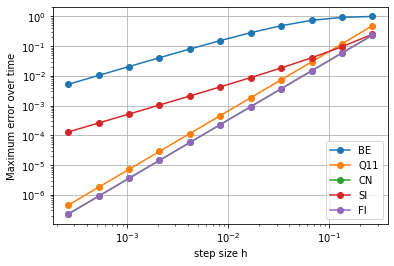

,h,BE-relative error,Q11-relative error,CN-relative error,SI-relative error,FI-relative error
0,2.6667e-01,9.999665e-01,2.086570e-01,6.661338e-16,1.538396e-01,8.903989e-14
1,1.3333e-01,9.949405e-01,2.398591e-02,1.332268e-15,7.142441e-02,1.847411e-13
2,6.6667e-02,9.301048e-01,2.967350e-03,1.110223e-15,3.448274e-02,1.383782e-12
3,3.3333e-02,7.362077e-01,3.704389e-04,5.107026e-15,1.694891e-02,4.218847e-15
4,1.6667e-02,4.865353e-01,4.629737e-05,1.665335e-15,8.403348e-03,2.442491e-15
5,8.3333e-03,2.834604e-01,5.787054e-06,6.217249e-15,4.184016e-03,2.675637e-14
6,4.1667e-03,1.535171e-01,7.233799e-07,4.773959e-15,2.087683e-03,4.380940e-13
7,2.0833e-03,7.995542e-02,9.042246e-08,5.773160e-15,1.042752e-03,3.275158e-14
8,1.0417e-03,4.081052e-02,1.130282e-08,8.659740e-15,5.211047e-04,4.052314e-14
9,5.2083e-04,2.061782e-02,1.412851e-09,1.088019e-14,2.604845e-04,2.131628e-14


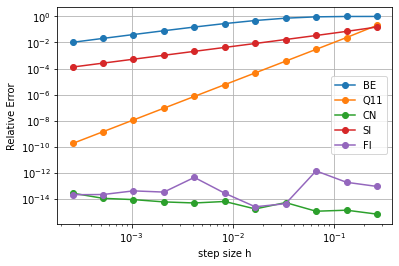

Results for r=4


,h,BE-error,BE-eoc,Q11-error,Q11-eoc,CN-error,CN-eoc,SI-error,SI-eoc,FI-error,FI-eoc
0,2.6667e-01,1.245470e+00,nan,inf,nan,1.671371e+00,nan,1.806380e+00,nan,1.310316e-01,nan
1,1.3333e-01,1.391192e+00,-0.160,1.586126e+00,inf,5.155216e-01,1.697,5.503766e-01,1.715,3.303088e-02,1.988
2,6.6667e-02,1.651777e+00,-0.248,3.242903e-01,2.290,1.270702e-01,2.020,1.347051e-01,2.031,8.290990e-03,1.994
3,3.3333e-02,1.777689e+00,-0.106,5.871152e-02,2.466,3.153826e-02,2.010,3.330688e-02,2.016,2.070885e-03,2.001
4,1.6667e-02,1.797906e+00,-0.016,1.201850e-02,2.288,7.868552e-03,2.003,8.303854e-03,2.004,5.170373e-04,2.002
5,8.3333e-03,1.865162e+00,-0.053,2.677790e-03,2.166,1.966082e-03,2.001,2.971172e-03,1.483,1.292387e-04,2.000
6,4.1667e-03,1.940380e+00,-0.057,6.288112e-04,2.090,4.914533e-04,2.000,1.487067e-03,0.999,3.230928e-05,2.000
7,2.0833e-03,1.535497e+00,0.338,1.521329e-04,2.047,1.228590e-04,2.000,7.439090e-04,0.999,8.077294e-06,2.000
8,1.0417e-03,1.013199e+00,0.600,3.739998e-05,2.024,3.071435e-05,2.000,3.720478e-04,1.000,2.019433e-06,2.000
9,5.2083e-04,5.788232e-01,0.808,9.270844e-06,2.012,7.678542e-06,2.000,1.860472e-04,1.000,5.048364e-07,2.000


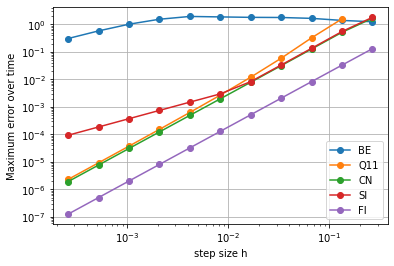

,h,BE-relative error,Q11-relative error,CN-relative error,SI-relative error,FI-relative error
0,2.6667e-01,9.999999e-01,nan,1.839289e-02,1.682538e-01,9.368096e-08
1,1.3333e-01,9.996204e-01,2.810778e-02,4.504105e-03,7.642963e-02,1.231053e-07
2,6.6667e-02,9.724813e-01,3.994322e-03,1.120596e-03,3.651316e-02,4.561630e-07
3,3.3333e-02,7.776251e-01,6.378451e-04,2.798172e-04,1.785257e-02,6.087696e-08
4,1.6667e-02,4.535850e-01,1.146536e-04,6.993642e-05,8.827914e-03,1.902427e-09
5,8.3333e-03,2.214242e-01,2.307004e-05,1.748215e-05,4.389656e-03,5.945655e-11
6,4.1667e-03,1.047656e-01,5.068741e-06,4.370440e-06,2.188790e-03,1.841194e-12
7,2.0833e-03,4.970915e-02,1.179870e-06,1.092601e-06,1.092890e-03,5.617729e-14
8,1.0417e-03,2.447618e-02,2.840561e-07,2.731487e-07,5.460695e-04,1.998401e-14
9,5.2083e-04,1.208902e-02,6.965035e-08,6.828708e-08,2.729409e-04,1.731948e-14


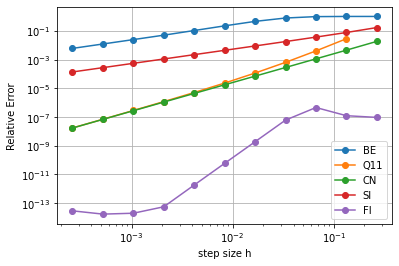

In [10]:
### Q2.4
# Defining new Newtwon function
def newton2(f, df, x0, eps, K):
    count = 0
    x  = x0
    Fx = f(x)
    while Fx*Fx > eps*eps and count<K:
        x = x - (Fx/df(x))
        Fx = f(x)
        count += 1
    return x, count

# Implementing fully implicit (FI) method
def FI(V, dV, t0, y0, h):
    x0 = y0[0]
    p0 = y0[1]
    F = lambda d: d - p0 + (V(x0 + h*d) - V(x0))/(2*d)
    DF = lambda d: 1 + ((h*dV(x0+h*d))/(2*d)) - ((V(x0 + h*d) - V(x0))/(2*d**2))
    delta, _ = newton2(F, DF, p0, h*h*1e-5, 1000)
    x1 = x0 + h*delta
    p1 = p0 - h*(V(x1) - V(x0))/(x1-x0)
    return np.array([x1, p1])

def fullyImplicit( V,dV, t0,y0, h):
    x = y0[0]
    p = y0[1]
    F = lambda xnew: array([xnew[0] - x - h*p + h**2/2 * (V(xnew[0]) - V(x)) /(xnew[0] - x)])
    DF = lambda xnew: array([[1 + h**2/2 *(dV(xnew[0])*(xnew[0]-x) - (V(xnew[0])-V(x)))/(xnew[0]-x)**2]])
    x0 = x+h*p-h**2/2*dV(x)
    xnew,n = newton(F,DF,array([x0]),1e-5*h*h,1000)
    assert n < 1000
    pnew = p - h * ( V(xnew[0]) - V(x) ) / (xnew[0] - x)
    return array([xnew[0],pnew])


### Performing tests

## r=2
my_hamFI = experiment(FI, M3, N03, V_2, dV_2, Y3, T3, y03)
# Plotting results for all methods
print('Results for r=2')
compareErrors({"BE":my_hamBE, "Q11":my_hamQ11, "CN":my_hamCN, "SI":my_hamSI, "FI":my_hamFI})
# Plotting relative errors for all methods
re_FI_2 = rel_e(FI, M3, N03, V_2, dV_2, Y3, T3, y03, V_2)
compare_relErrors({"BE":re_BE_2, "Q11":re_Q11_2, "CN":re_CN_2, "SI":re_SI_2, "FI":re_FI_2})

## r=4
hamFI = experiment(FI, M2, N02, V_4, dV_4, Y2, T2, y02)
# Plotting results for all methods
print('Results for r=4')
compareErrors({"BE":hamBE, "Q11":hamQ11, "CN":hamCN, "SI":hamSI, "FI":hamFI})
# Plotting relative errors for all methods
re_FI_4 = rel_e(FI, M2, N02, V_4, dV_4, Y2, T2, y02, V_4)
compare_relErrors({"BE":re_BE_4, "Q11":re_Q11_4, "CN":re_CN_4, "SI":re_SI_4, "FI":re_FI_4})

Discussion of Q2.2, Q2.3, Q2.4
---

In the first 3 methods in the table (Which we formulated and produced the reuslts for in Q2.2), for $r=2$ we see that the backward Euler method has EOCs converging to 1 implying a rate of convergence of $O(h)$, which we saw in our first assignment and lectures. We see that the Q11 method has EOCs converging to 2 implying a rate of convergence of $O(h^2)$, which we saw in our first assignment and lectures as well. Finally we also see that the Crank-Nicholson method has EOCs converging to 2 implyiong a order of convergence $O(h^2)$ similar to Q11 method. When $r=4$ we see all methods mentioned so far have the same rates of convergence since the EOCs appear to be converging to the same values.

Now in Q2.3 we implemented the *semi-implict*(SI) method and from our table, in both the $r=2$ and $r=4$ case, that the EOCs of the SI method converge to 1 implying a rate of convergence $O(h)$. We also see in both values of r that the maximum errors of the SI method as h decreased were larger than the Crank-Nicholson and the Q11 method but were smaller than the backward Euler method, which had the largest maximum error values across the methods.

In Q2.4 we implemented the *fully-implict*(FI) method. We see from our tables, for both values of r, that the EOCs for this method appear to converge to 2 implying a rate of convergence of $O(h^2)$. For $r=2$ we see that the maximum errors for the FI method are almost identical to those for the Crank-Nicholson method. For $r=4$ the maximum errors are larger than for any other method.

For the initial guess in the newton method in Q2.4 we chose $p_0$. This is because assuming that V($x_n$ + $\delta$ h) is approximately equal to V($x_n$) for small h we see that in our equation '$F$' in the newton method (defined in  Q2.4) we get cancellation to achcieve $F(\delta) =\delta - p_0$. We are looking for a root of this equation and so we conclude our guess to be $\delta = p_0$.

Now discussing the relative errors. There are some discrepancies in the realtive error results obtained for FI method however it is easy to see the big picture. For $r=2$ we see that the Crank_Nicholson method performs the best, then comes the FI method, followed by the Q11 method, then the SI method and finally the backward Euler method. For $r=4$ we see a difference in performance. Now the FI method performs the best, then the Crank-Nicholson method, then the Q11 method, followed by the SI method and finally the backwarwd Euler method again.
